# Tests with different dataset sizes

In [1]:
import os

# 2x 2 chips (4 cores) per process:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,2,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0,1" # Change to "2,3" for the second machine
# Pick a unique port per process
os.environ["TPU_MESH_CONTROLLER_ADDRESS"] = "localhost:8476"
os.environ["TPU_MESH_CONTROLLER_PORT"] = "8476"

import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(0,1,0), core_on_chip=1)]

In [2]:
import jax.numpy as jnp

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/gerardoduran/documents/Personalized-News-Recommendation'

In [4]:
# We need direct access to the Zeus project
!ls ../zeus/

LICENSE      __pycache__  bbj-deprecated    notebooks	      scripts
README.md    bandit-data  bbj_vs_bandit.py  paper
__init__.py  bandits	  misc		    requirements.txt


In [5]:
import sys
sys.path.append("..") # access zeus

In [6]:
%load_ext autoreload
%autoreload 2
from bandits import *
from evaluator import evaluate
from matplotlib import pyplot as plt
import pandas as pd

In [178]:
%config InlineBackend.figure_format = "retina"

In [7]:
%%time
import dataset
base_dir = "../zeus/bandit-data/R6"
files = ["ydata-fp-td-clicks-v1_0.20090503", "ydata-fp-td-clicks-v1_0.20090510"]
files = ["ydata-fp-td-clicks-v1_0.20090503"]
files = [os.path.join(base_dir, file) for file in files]
dataset.get_yahoo_events(files)

3966363 events with 39 articles
CPU times: user 1min 51s, sys: 3.51 s, total: 1min 54s
Wall time: 1min 54s


## Evaluator descriptor

Running `dataset.get_yahoo_events(files)` defines the following variables for `datasets`
1. `n_arms`
2. `n_events`
3. `features`
4. `events`
5. `articles` List of observed articles

In [8]:
dataset.n_arms

39

In [9]:
dataset.n_events

3966363

In [17]:
# Features of each of the articles
dataset.features.shape

(39, 6)

In [11]:
# List containing:
# 1. Position of the shown article
# 2. Whether the article was clicked or not
# 3. The user features
# 4. The indices of the articles in the context
dataset.events[0]

[11,
 0,
 [0.000719, 1.6e-05, 0.00018, 0.000401, 0.998684, 1.0],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]

In [12]:
dataset.articles[11]

'109565'

### Sample of values for testing/debugging

In [836]:
sample_size = 1_000_000
events_sample = dataset.events[:sample_size]

pct_data = len(events_sample) / len(dataset.events)
print(f"Percentage of data used: {pct_data:0.2%}")

Percentage of data used: 25.21%


Parsing dataset to run inside the TPU using Jax

In [837]:
from tqdm.notebook import tqdm

In [838]:
chosen_articles_samp = []
clicked_samp = []
user_features_samp = []
articles_context_samp = []

for event in tqdm(events_sample):
    chosen_article, clicked, user_features, articles_context = event
    if len(articles_context) != 19:
        continue
    
    chosen_articles_samp.append(chosen_article)
    clicked_samp.append(clicked)
    user_features_samp.append(user_features)
    articles_context_samp.append(articles_context)
    
articles_context_samp = jnp.array(articles_context_samp, dtype=int)
chosen_articles_samp = jnp.array(chosen_articles_samp)
clicked_samp = jnp.array(clicked_samp, dtype=float)
user_features_samp = jnp.array(user_features_samp)

# np -> jnp
articles_features = jnp.array(dataset.features)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [852]:
n_articles = len(articles_context_samp)
print(f"{n_articles:,}")

985,105


# Replay Method

$$
    g_\pi = \frac{G_\pi(T)}{T} = \frac{1}{T}\mathbb{E}\left[\sum_{t=1}^T r_{t, a_{t}}\right]
$$

In [839]:
from zeus.bandits.agents import linear_bandit, linear_kf_bandit

In [853]:
class OfflineReplayYahoo:
    def __init__(self, bandit, articles_features):
        self.bandit = bandit
        self.articles_features = articles_features
    
    @staticmethod
    def is_accepted_action(observed_action, estimated_action):
        accepted = jax.lax.cond(observed_action == estimated_action, lambda _: True, lambda _: False, None)
        return accepted
    
    def update_if_accepted(self, observed_action, estimated_action, input_vals):
        """
        Parameters
        ----------
        observed_action: int
            The observed action in the logs
        estimated_action: int
            Action chosen by the bandit
        input_vals: tuple
            (params, total_reward, n_events, action, context, reward)
        """
        ans = jax.lax.cond(observed_action == estimated_action, self.replay_update, lambda _: input_vals[:3], input_vals)
        return ans

    def replay_update(self, xs):
        params, total_reward, n_events, action, context, reward = xs
        params = self.bandit.update_bel(params, context, action, reward)
        total_reward = total_reward + reward
        n_events = n_events + 1
        return params, total_reward, n_events

    def replay_step(self, state, xs):
        params, total_reward, n_events = state
        key, observed_action, user_features, context_articles, reward = xs
        
        # Retrieve article features and create the context
        articles_context = self.articles_features[context_articles, :].ravel()
        context = jnp.concatenate([user_features, articles_context])

        action_est = self.bandit.choose_action(key, params, context)

        input_val = (params, total_reward, n_events, action_est, context, reward)

        params, total_reward, n_events = self.update_if_accepted(observed_action, action_est, input_val)
        carry_ = self.is_accepted_action(observed_action, action_est)
        return (params, total_reward, n_events), (total_reward, n_events, carry_)
    
    def run(self, key, init_params, users_features, observed_articles, articles, rewards):
        num_obs, *_ = users_features.shape
        key_steps = jax.random.split(key, num_obs)
        init_state = (init_params, 0.0, 0.0)
        xs = (key_steps, observed_articles, users_features, articles, rewards)
        res, hist = jax.lax.scan(self.replay_step, init_state, xs)
        return res, hist
    
    def run_vmap(self, key, init_params, context, actions, rewards, num_trials):
        keys = jax.random.split(key, num_trials)
        run_part = partial(self.run, init_params=init_params, context=context, actions=actions, rewards=rewards)
        run_part_vmap = jax.vmap(lambda k: run_part(k))
        return run_part_vmap(keys)
    
class RandomBandit:
    def __init__(self, num_arms):
        self.num_arms = num_arms
    
    def choose_action(self, key, *args, **kwargs):
        return jax.random.choice(key, self.num_arms)
    
    def update_bel(self, bel, *args, **kwargs):
        return bel
    

class EpsilonGreedy:
    def __init__(self, epsilon, num_arms):
        self.epsilon = epsilon
        self.num_arms = num_arms
        
    def init_bel(self):
        return {
            "num_visits": jnp.zeros(self.num_arms),
            "cumulative_rewards": jnp.zeros(self.num_arms)
        }
    
    def choose_action(self, key, bel, *args):
        key_greedy, key_action_greedy, key_action_random = jax.random.split(key, 3)
        num_visits = bel["num_visits"]
        cumulative_rewards = bel["cumulative_rewards"]

        Qt = cumulative_rewards / jnp.maximum(num_visits, 1)
        take_greedy = (jax.random.uniform(key_greedy) > self.epsilon) * 1.0

        map_choice = Qt.max() == Qt
        prob_choice_Q = map_choice / map_choice.sum()

        greedy_action = jax.random.choice(key_action_greedy, self.num_arms, p=prob_choice_Q)
        random_action = jax.random.choice(key_action_random, self.num_arms)

        action = take_greedy * greedy_action + (1 - take_greedy) * random_action
        
        return action
        
    
    def update_bel(self, bel, _, action, reward):
        num_visits = bel["num_visits"]
        cumulative_rewards = bel["cumulative_rewards"]
        
        action_ohe = jax.nn.one_hot(action, self.num_arms)
        num_visits = num_visits + action_ohe
        cumulative_rewards = cumulative_rewards + action_ohe * reward
        
        return {
            "num_visits": num_visits,
            "cumulative_rewards": cumulative_rewards
        }

        

In [854]:
%whos DeviceArray

Variable                   Type           Data/Info
---------------------------------------------------
T_hist                     DeviceArray    [ 1.  2.  3.  4.  5.  6. <...>8.\n 19. 20. 21. 22. 23.]
actions_samp               DeviceArray    [11  0  4  9  9]
articles_context_samp      DeviceArray    [[ 0  1  2 ... 16 17 18]\<...> [ 0  1  2 ... 16 17 18]]
articles_context_train     DeviceArray    [[ 0  1  2 ... 16 17 18]\<...> [ 0  1  2 ... 16 17 18]]
articles_context_warmup    DeviceArray    [[4.21669e-01 1.10000e-05<...>2.50099e-01 1.00000e+00]]
articles_features          DeviceArray    [[4.21669e-01 1.10000e-05<...>2.83587e-01 1.00000e+00]]
avg_reward                 DeviceArray    0.04347826
avg_reward_eps             DeviceArray    0.044950377
avg_reward_hist            DeviceArray    [0.         0.         0.<...>05 0.04545455 0.04347826]
avg_reward_hist_eps        DeviceArray    [       nan 0.         0.<...>38 0.04495038 0.04495038]
avg_reward_hist_random     DeviceArray    [0

In [855]:
user_features = user_features_samp[0]
articles_context = articles_context_samp[0]
context = jnp.concatenate([user_features, articles_features[articles_context, :].ravel()])

num_features = len(context)
num_arms, _ = dataset.features.shape

### Initialise bandit

In [856]:
bandit = linear_kf_bandit.LinearKFBandit(num_features, num_arms, eta=6.0, lmbda=0.25)
env = OfflineReplayYahoo(bandit, articles_features)

In [857]:
n_warmup = 5
articles_context_warmup = articles_context_samp[:n_warmup, :]
articles_context_warmup = articles_features[articles_context_warmup].reshape(n_warmup, -1)

user_context_warmup = user_features_samp[:n_warmup]

context_warmup = jnp.concatenate((user_context_warmup, articles_context_warmup), axis=1)

In [858]:
rewards_samp = clicked_samp[:n_warmup]
actions_samp = chosen_articles_samp[:n_warmup]

belief_state = bandit.init_bel(None, context_warmup, None, actions_samp, rewards_samp)

### Run bandit

In [865]:
user_features_train = user_features_samp[n_warmup:, :]
chosen_articles_train = chosen_articles_samp[n_warmup:]
articles_context_train = articles_context_samp[n_warmup:, :]
clicked_train = clicked_samp[n_warmup:]

In [ ]:
key = jax.random.PRNGKey(314)
final_belief_state, (total_reward_hist, n_events_hist, carry_hist) = env.run(key, belief_state, user_features_train,
                                                                             chosen_articles_train, articles_context_train, clicked_train)

In [770]:
%%time
avg_reward_hist = (total_reward_hist[carry_hist] / n_events_hist[carry_hist]).block_until_ready()
avg_reward = avg_reward_hist[-1]
print(f"Avg reward: {avg_reward:0.4f}")

Avg reward: 0.0435
CPU times: user 17.2 ms, sys: 582 µs, total: 17.7 ms
Wall time: 7.59 ms


In [774]:
f"{len(carry_hist):,}"

'199,995'

Text(0, 0.5, 'Avg Reward')

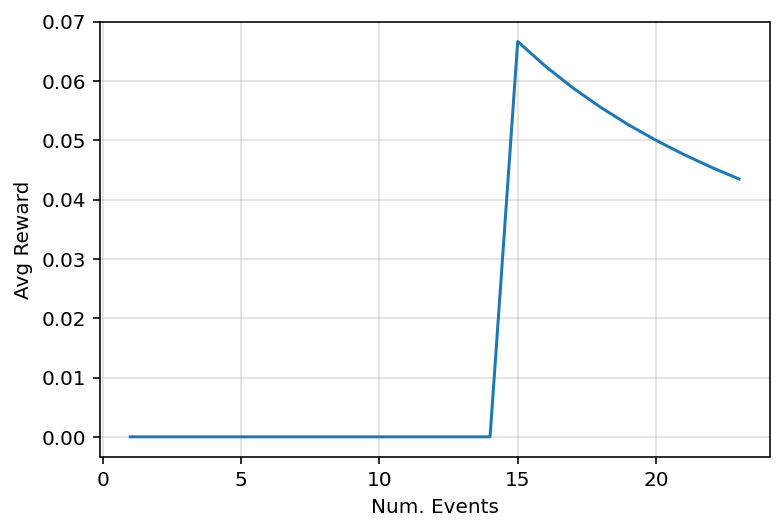

In [775]:
T_hist = n_events_hist[carry_hist]
# click-through-rate
plt.plot(T_hist, avg_reward_hist)
plt.grid(alpha=0.4)
plt.xlabel("Num. Events")
plt.ylabel("Avg Reward")

## Run random-policy bandit

In [866]:
random_bandit = RandomBandit(num_arms)
random_env = OfflineReplayYahoo(random_bandit, articles_features)

In [867]:
_, hist = random_env.run(key, belief_state, user_features_train,
                         chosen_articles_train, articles_context_train, clicked_train)
total_reward_hist_random, n_events_hist_random, carry_hist_random = hist

In [868]:
%%time
avg_reward_hist_random = total_reward_hist_random[carry_hist_random] / n_events_hist_random[carry_hist_random]
avg_reward_random = avg_reward_hist_random[-1]
print(f"Avg random reward: {avg_reward_random:0.4f}")

Avg random reward: 0.0275
CPU times: user 285 ms, sys: 5.42 ms, total: 290 ms
Wall time: 20.9 s


### Relative CTR

In [869]:
print(f"{len(carry_hist_random):,}")

985,100


In [870]:
relative_ctr = avg_reward / avg_reward_random
print(f"relative CTR: {relative_ctr:0.3f}")

relative CTR: 1.583


## Epislon-greedy Policy

In [871]:
eps = 0.1
eps_bandit = EpsilonGreedy(eps, num_arms)
eps_env = OfflineReplayYahoo(eps_bandit, articles_features)
init_bel = eps_bandit.init_bel()

In [872]:

eps_bel, hist = eps_env.run(key, init_bel, user_features_train,
                         chosen_articles_train, articles_context_train, clicked_train)
total_reward_hist_eps, n_events_hist_eps, carry_hist_eps = hist

In [873]:
%%time
avg_reward_hist_eps = total_reward_hist_eps[carry_hist_eps] / n_events_hist_random[carry_hist_eps]
avg_reward_eps = avg_reward_hist_eps[-1]
print(f"Avg random reward: {avg_reward_eps:0.4f}")

Avg random reward: 0.0944
CPU times: user 420 ms, sys: 8.95 ms, total: 429 ms
Wall time: 47.7 s


### Relative CTR

In [874]:
relative_ctr = avg_reward_eps / avg_reward_random
print("Epsilon-greedy")
print(f"relative CTR: {relative_ctr:0.3f}")

Epsilon-greedy
relative CTR: 3.439


----

## Original stuff

In [26]:
_, deploy = evaluate(Egreedy(1))
rnd_ctr = deploy[-1]

Egreedy (ε=1)       0.0326    16.8s


In [61]:
np.prod(dataset.features.shape)

234

In [58]:
dataset.features.shape

(39, 6)

In [80]:
# Number of times the article was clicked
np.array([event[1] for event in dataset.events]).mean()

0.031318616072205194

Egreedy (ε=0.1)     0.0424    21.6s
Egreedy (ε=0.1)     0.041     17.0s
Egreedy (ε=0.1)     0.041     8.8s
Egreedy (ε=0.1)     0.0456    5.2s


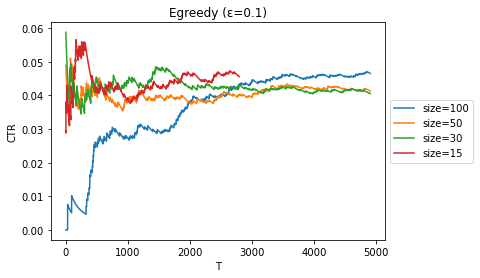

UCB1 (α=0.1)        0.0415    48.7s
UCB1 (α=0.1)        0.0419    28.2s
UCB1 (α=0.1)        0.0484    16.3s
UCB1 (α=0.1)        0.0445    8.1s


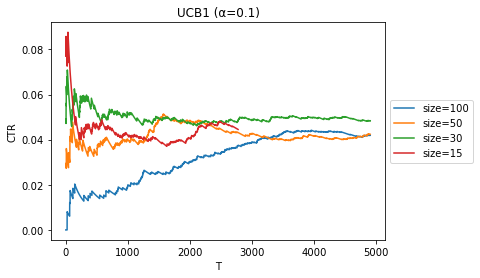

LinUCB (α=0.3, context:both)0.0537    4.5m
LinUCB (α=0.3, context:both)0.0521    2.4m
LinUCB (α=0.3, context:both)0.0501    1.4m
LinUCB (α=0.3, context:both)0.0478    42.1s


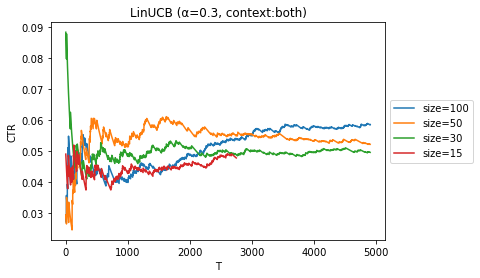

LinUCB (α=0.3, context:user)0.0477    3.2m
LinUCB (α=0.3, context:user)0.0504    1.7m
LinUCB (α=0.3, context:user)0.0515    1.0m
LinUCB (α=0.3, context:user)0.0526    30.4s


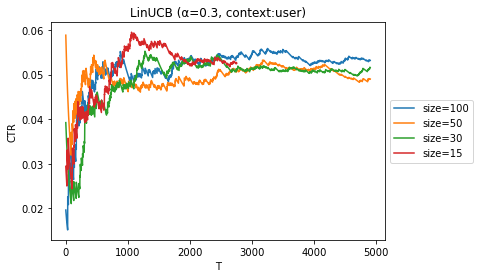

In [27]:
sizes = [100,50,30,15]
results = [['Size','Bucket','Algorithm','CTR Lift']]

algorithms = [Egreedy(0.1),Ucb1(0.1),LinUCB(0.3, context="both"), LinUCB(0.3, context="user")]

for test in algorithms:
    for size in sizes:
        learn ,deploy = evaluate(test,size=size)
        results.append([size,'learn',test.algorithm, learn[-1]/rnd_ctr])
        results.append([size,'deploy',test.algorithm, deploy[-1]/rnd_ctr])
        
        plt.plot(deploy[100:5000], label="size={}".format(size))
        
    plt.title(test.algorithm)
    plt.xlabel("T")
    plt.ylabel("CTR")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [6]:
df = pd.DataFrame(results)
df.columns = df.iloc[0]
df = df[1:]
df

,Size,Bucket,Algorithm,CTR Lift
1,100,learn,Egreedy (ε=0.1),1.425223
2,100,deploy,Egreedy (ε=0.1),1.406137
3,50,learn,Egreedy (ε=0.1),1.439401
4,50,deploy,Egreedy (ε=0.1),1.413857
5,30,learn,Egreedy (ε=0.1),1.422329
6,30,deploy,Egreedy (ε=0.1),1.507054
7,15,learn,Egreedy (ε=0.1),1.423876
8,15,deploy,Egreedy (ε=0.1),1.520571
9,100,learn,UCB1 (α=0.1),1.472481
10,100,deploy,UCB1 (α=0.1),1.508754
